# Churn modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [5]:
# Load dataset
telco = pd.read_csv('data/telco.csv', index_col='customerID')
telco.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
telco.shape

(7043, 20)

**Understanding Customer Churn :**

**What is Customer Churn?**

Customer churn refers to when a customer ends his or her relationship with a business.

**Why do customers churn?**

Even though there are a variety of factors influencing churn, it mostly comes down to one of the following reasons:

- The customer is frustrated with the product experience.
- The cost for the product exceeds the value it provides.
- The product lacks appropriate customer support.
- Attracting the wrong customers.

**Why do we want to predict churn?**

Acquiring new customers can be several times more expensive than selling to existing ones. Understanding what drives churn and why customers are churning is crucial in maintaining high retention rates. Being able to accurately identify those customers at high risk of churning, may help us to create appropriate marketing strategies and retain our customers.

# EDA

## Types

In [36]:
# Types
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# TotalCharges must be encoded as numeric
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')
telco.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Missing values and unique values

In [12]:
# Function to check for unique values, Nan and zeros
def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col, len(unique_values), nans,  zeros]).T, ignore_index = True)
    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %'})
                                
missing_values(telco)

,variable,Unique values,Nan %,zeros %
0,gender,2,0.0,0.0
1,SeniorCitizen,2,0.0,83.8
2,Partner,2,0.0,0.0
3,Dependents,2,0.0,0.0
4,tenure,73,0.0,0.2
5,PhoneService,2,0.0,0.0
6,MultipleLines,3,0.0,0.0
7,InternetService,3,0.0,0.0
8,OnlineSecurity,3,0.0,0.0
9,OnlineBackup,3,0.0,0.0


**=>** There is only Nans in TotalCharges. All categorical variables have low cardinality.

## Distribution

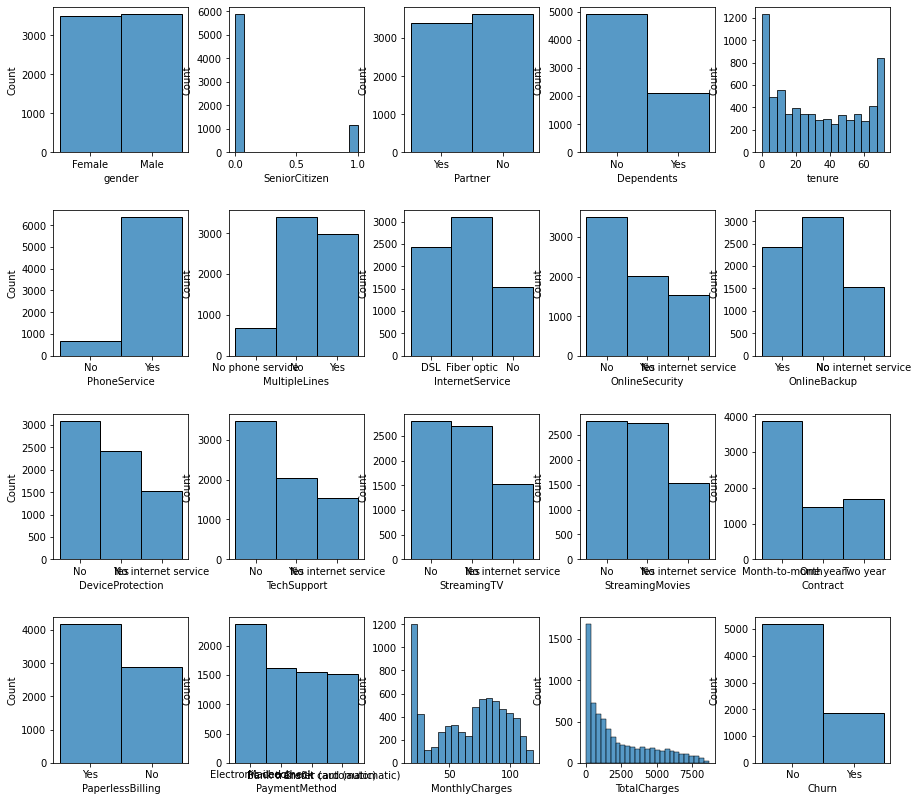

In [15]:
# Univariate analysis
# Let's create histograms for all our variables
fig, ax = plt.subplots(4,5,figsize=(15,12))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)

for var, sub in zip(telco.columns, ax.flatten()):
    sns.histplot(telco[var], ax=sub)

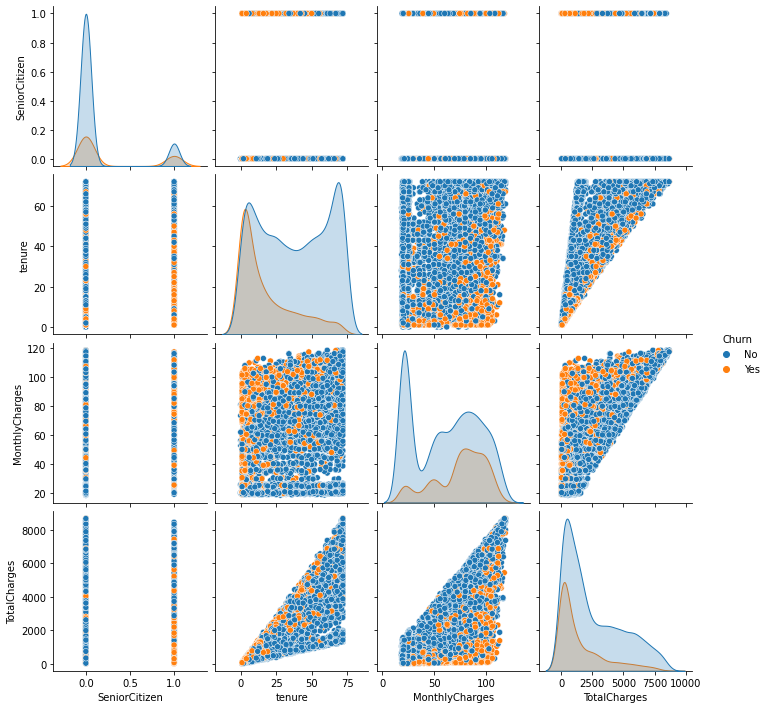

In [17]:
# Bivariate analysis with Churn, for numerical variables
sns.pairplot(data=telco, hue='Churn')
plt.show()

**=>** We can see that churned customers tend to have a lower tenure while at the same time having higher monthly charges.

# Preprocessing

# Model & training

# Predictions and Model evaluation

# Conclusion

# ML modeling

**Supervised learning steps :**
1. Split data to training and testing
2. Initialize the model
3. Fit the model on the training data
4. Predict values on the testing data

In [ ]:
# # 1. Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# # 2. Initialize the model
# init_tree = tree.DecisionTreeClassifier(max_depth=7, criterion='gini', splitter='best')

# # 3. Fit the model on the training data
# model_tree = init_tree.fit(X_train, y_train)

# # 4. Predict values on the testing data
# y_pred = model_tree.predict(X_test)

# # 5. Measure model perf on testing data
# accuracy_score(y_test, y_pred)

**Unsupervised learning steps :**
1. Initialize the model
2. Fit the model
3. Assign cluster values
4. Explore results

In [ ]:
# # 1. Initialize the model
# kmeans = KMeans(n_clusters=3)

# # 2. Fit the model
# kmeans.fit(data)

# # 3. Assign cluster values
# data.assign(Cluster=kmeans.labels_)

# # 4. Explore results
# data.groupby('Cluster').mean()

Suite : 
https://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c7523 => mieux